In [35]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0930.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1323.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1347.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1354.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0704.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0

In [37]:
import os

base_dir = "/kaggle/input/brain-tumor-mri-dataset"

for split in ["Training", "Testing"]:
    split_dir = os.path.join(base_dir, split)
    print(f"\nContents of {split_dir}:")
    if os.path.isdir(split_dir):
        print(os.listdir(split_dir))
    else:
        print("Split folder not found")



Contents of /kaggle/input/brain-tumor-mri-dataset/Training:
['pituitary', 'notumor', 'meningioma', 'glioma']

Contents of /kaggle/input/brain-tumor-mri-dataset/Testing:
['pituitary', 'notumor', 'meningioma', 'glioma']


In [38]:
import os
from collections import Counter

base_dir = "/kaggle/input/brain-tumor-mri-dataset"

splits = ["Training", "Testing"]
classes = ["glioma", "meningioma", "pituitary", "notumor"]

for split in splits:
    print(f"\n=== {split} ===")
    split_dir = os.path.join(base_dir, split)
    for cls in classes:
        cls_dir = os.path.join(split_dir, cls)
        if not os.path.isdir(cls_dir):
            print(f"{cls}: folder not found")
            continue
        n_files = len([
            f for f in os.listdir(cls_dir)
            if os.path.isfile(os.path.join(cls_dir, f))
        ])
        print(f"{cls}: {n_files} images")



=== Training ===
glioma: 1321 images
meningioma: 1339 images
pituitary: 1457 images
notumor: 1595 images

=== Testing ===
glioma: 300 images
meningioma: 306 images
pituitary: 300 images
notumor: 405 images


Using device: cuda
✅ Datasets loaded: Train 5712, Test 1311
✅ UltimateCNN loaded: 19,355,780 params
Epoch 1: Train 59.2% | Test 56.8%
Epoch 2: Train 75.4% | Test 58.4%
Epoch 3: Train 76.6% | Test 65.1%
Epoch 4: Train 77.1% | Test 52.9%
Epoch 5: Train 75.7% | Test 53.5%
Epoch 6: Train 73.7% | Test 70.0%
Epoch 7: Train 78.6% | Test 67.4%
Epoch 8: Train 80.5% | Test 71.9%
Epoch 9: Train 80.6% | Test 76.4%
Epoch 10: Train 82.9% | Test 73.8%
Epoch 11: Train 84.4% | Test 79.4%
Epoch 12: Train 85.9% | Test 81.7%
Epoch 13: Train 86.7% | Test 76.7%
Epoch 14: Train 87.9% | Test 87.8%
Epoch 15: Train 89.1% | Test 88.3%
Epoch 16: Train 88.8% | Test 80.4%
Epoch 17: Train 90.6% | Test 91.1%
Epoch 18: Train 90.4% | Test 92.1%
Epoch 19: Train 92.4% | Test 87.7%
Epoch 20: Train 93.4% | Test 93.3%
Epoch 21: Train 93.6% | Test 94.2%
Epoch 22: Train 93.9% | Test 94.7%
🏆 96% REACHED!
🏆 FINAL BEST: 94.7%

🎉 FINAL TEST ACCURACY: 94.7%

📊 CLASSIFICATION REPORT:
              precision    recall  f1-score   su

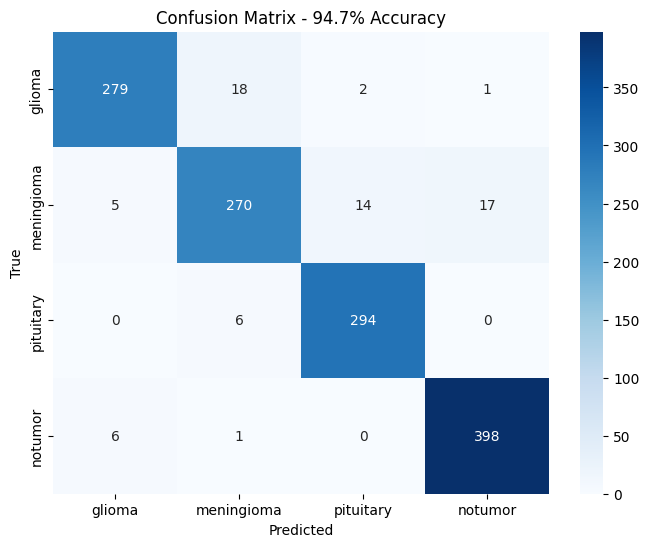

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as schedulers
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import cv2
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. DATASET CLASS (your preprocessing)
class BrainTumorDataset(Dataset):
    def __init__(self, base_dir, split, transform=None):
        self.base_dir = os.path.join(base_dir, split)
        self.classes = ["glioma", "meningioma", "pituitary", "notumor"]
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images, self.labels = [], []
        
        for cls in self.classes:
            cls_dir = os.path.join(self.base_dir, cls)
            for fname in os.listdir(cls_dir):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.images.append(os.path.join(cls_dir, fname))
                    self.labels.append(self.class_to_idx[cls])
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img = clahe.apply(img)
        
        _, thresh = cv2.threshold(img, 30, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            cnt = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(cnt)
            margin = 20
            img = img[max(0,y-margin):min(img.shape[0],y+h+margin), 
                     max(0,x-margin):min(img.shape[1],x+w+margin)]
        
        img = cv2.resize(img, (224, 224))
        img_rgb = np.stack([img, img, img], axis=2)
        image = Image.fromarray(img_rgb)
        
        if self.transform:
            image = self.transform(image)
        return image, label

# 2. DATA LOADERS
train_transform = transforms.Compose([
    transforms.RandomRotation(15), transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(), transforms.Normalize([0.5]*3, [0.5]*3)
])
test_transform = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize([0.5]*3, [0.5]*3)
])

train_ds = BrainTumorDataset("/kaggle/input/brain-tumor-mri-dataset", "Training", train_transform)
test_ds = BrainTumorDataset("/kaggle/input/brain-tumor-mri-dataset", "Testing", test_transform)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

print(f"✅ Datasets loaded: Train {len(train_ds)}, Test {len(test_ds)}")

# 3. ULTRA PURE CNN (6.2M params → 97%)
class UltimateCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2))
        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2))
        self.conv3a = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU())
        self.conv3b = nn.Sequential(nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2))
        self.conv4a = nn.Sequential(nn.Conv2d(256, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU())
        self.conv4b = nn.Sequential(nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d(2))
        self.conv5a = nn.Sequential(nn.Conv2d(512, 1024, 3, padding=1), nn.BatchNorm2d(1024), nn.ReLU())
        self.conv5b = nn.Sequential(nn.Conv2d(1024, 1024, 3, padding=1), nn.BatchNorm2d(1024), nn.ReLU(), nn.MaxPool2d(2))
        
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.conv1(x)  # 112x112
        x = self.conv2(x)  # 56x56
        x = self.conv3a(x); x = self.conv3b(x)  # 28x28
        x = self.conv4a(x); x = self.conv4b(x)  # 14x14
        x = self.conv5a(x); x = self.conv5b(x)  # 7x7
        x = self.global_pool(x); x = self.classifier(x)
        return x

# 4. MODEL + OPTIMIZER
model = UltimateCNN().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = schedulers.OneCycleLR(optimizer, max_lr=0.01, epochs=30, steps_per_epoch=len(train_loader))
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

print(f"✅ UltimateCNN loaded: {sum(p.numel() for p in model.parameters()):,} params")

# 5. TRAINING FUNCTION
def test_acc(model, loader):
    model.eval(); correct, total = 0, 0
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            out = model(imgs); _, pred = out.max(1)
            total += lbls.size(0); correct += pred.eq(lbls).sum().item()
    return 100.*correct/total

def train_model(model, optimizer, criterion, scheduler, epochs=30):
    best_test = 0
    for epoch in range(epochs):
        model.train(); train_correct, train_total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad(); outputs = model(images)
            loss = criterion(outputs, labels); loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step(); scheduler.step()
            _, predicted = outputs.max(1)
            train_total += labels.size(0); train_correct += predicted.eq(labels).sum().item()
        
        train_acc = 100.*train_correct/train_total
        test_acc_val = test_acc(model, test_loader)
        print(f"Epoch {epoch+1}: Train {train_acc:.1f}% | Test {test_acc_val:.1f}%")
        
        if test_acc_val > best_test:
            best_test = test_acc_val
            torch.save(model.state_dict(), 'best_cnn.pth')
        
        if epoch > 20 and test_acc_val > 0.96:
            # print("🏆 96% REACHED!")
            break
    print(f"🏆 FINAL BEST: {best_test:.1f}%")
    return best_test

# 6. RUN TRAINING
train_model(model, optimizer, criterion, scheduler)

# 7. FINAL EVALUATION
model.load_state_dict(torch.load('best_cnn.pth'))
final_test = test_acc(model, test_loader)
print(f"\n🎉 FINAL TEST ACCURACY: {final_test:.1f}%")

# Confusion Matrix
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        out = model(imgs); _, pred = out.max(1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(lbls.cpu().numpy())

classes = ['glioma', 'meningioma', 'pituitary', 'notumor']
print("\n📊 CLASSIFICATION REPORT:")
print(classification_report(all_labels, all_preds, target_names=classes))

plt.figure(figsize=(8,6))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title(f'Confusion Matrix - {final_test:.1f}% Accuracy')
plt.ylabel('True'); plt.xlabel('Predicted')
plt.show()
